# Minimal example for PSM

In [1]:
import numpy as np
import pandas as pd
from yapsm import psm
from yapsm.utils import summary_imbalance, plot_imbalance

In [2]:
# make up some data in 2D
n_trt =100
n_ctl = 1000
ctl = pd.DataFrame(np.random.normal(0, 2, size=(n_ctl, 2)), index=[f"ctl_{i}" for i in range(n_ctl)], columns=['x1','x2'])
trt = pd.DataFrame(np.random.normal(1, 1, size=(n_trt, 2)), index=[f"trt_{i}" for i in range(n_trt)], columns=['x1','x2'])

ctl['group'] = 0
trt['group'] = 1
data = pd.concat([ctl, trt])
data.head()

,x1,x2,group
ctl_0,1.273064,3.058492,0
ctl_1,1.981045,-2.269298,0
ctl_2,1.405121,1.376463,0
ctl_3,0.943201,-0.276187,0
ctl_4,0.226687,-0.559450,0


## Fitting PSM

In [3]:
# apply PSM
p = psm.Yapsm(
    data,
    yvar="group",
    group_ctl=0,  #'ctl',
    group_trt=1,  #'trt'
)
# p.fit_scores(balance=False)
p.fit_scores(balance=True)
p.predict_scores()

INFO:yapsm.psm:Average Classification Accuracy: 70.7%


`p.predict_scores()` adds a `scores` column

In [4]:
p.data.head()

,x1,x2,group,scores
ctl_0,1.273064,3.058492,0,0.826466
ctl_1,1.981045,-2.269298,0,0.346843
ctl_2,1.405121,1.376463,0,0.697545
ctl_3,0.943201,-0.276187,0,0.465865
ctl_4,0.226687,-0.559450,0,0.360270


## Optimal Matching

In [5]:
optimal_matching = p.match_optimal(knn=150, n_max=2, caliper=0.25)
df_matched = p.get_psmatched_dataset(optimal_matching)

INFO:yapsm.optimal_match:kNN query (k=150)
INFO:yapsm.optimal_match:constructing Flow graph
INFO:yapsm.optimal_match:solving flow
INFO:yapsm.psm:Mapped 100 TRT  to 83 CTL
INFO:yapsm.psm:Total cost 0.059


`df_matched` contains less samples, but they're matched between `trt` and `ctl`

In [6]:
df_matched.head()

,x1,x2,group,scores
trt_39,0.512440,0.887154,1,0.557766
trt_62,2.322427,1.564355,1,0.784647
ctl_130,1.852173,1.483180,0,0.744139
ctl_137,1.767725,-0.712421,0,0.501130
ctl_751,-0.931897,1.292273,0,0.453527


### Visualizing the PSM with optimal matching
imbalance before PSM: `x1`, `x2` (ignore `scores`) between groups
- absolute differences (`mean_diff`)
- standardized differences (`std_mean_diff`)

In [7]:
summary_imbalance(data, 'group')

group,0,1,mean_diff,std,std_mean_diff,std_treat,std_treat_mean_diff,var_ratio
x1,0.009025,0.977735,0.968710,1.972802,0.491033,0.900019,1.076322,0.196808
x2,-0.134806,0.936187,1.070993,1.971566,0.543219,0.995748,1.075566,0.243404
scores,0.412116,0.601314,0.189198,0.237958,0.795088,0.128028,1.477780,0.285510


imbalance **after** PSM is reduced significantly

In [8]:
summary_imbalance(df_matched, 'group')

group,0,1,mean_diff,std,std_mean_diff,std_treat,std_treat_mean_diff,var_ratio
x1,1.054300,0.977735,-0.076565,1.221581,-0.062677,0.900019,-0.085071,0.347523
x2,0.916052,0.936187,0.020135,1.252293,0.016079,0.995748,0.020221,0.434223
scores,0.605094,0.601314,-0.003780,0.129237,-0.029245,0.128028,-0.029521,0.948916


Love plot

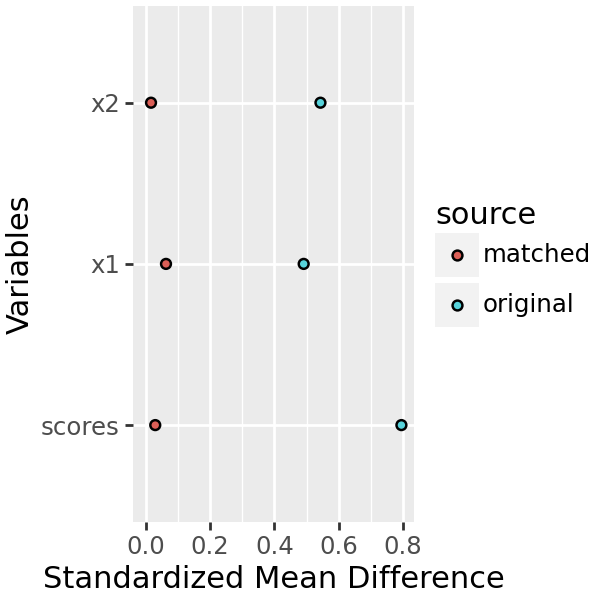

In [9]:
import plotnine as pn
plot_imbalance(data, df_matched, 'group') + pn.theme(figure_size=(3,3)) 

### Plot the matching

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
def plot_match(optimal_map, ctl, trt):

    _d = pd.concat([ctl, trt])
    plt.figure(figsize=(5, 5))
    plt.scatter(_d.x1, _d.x2, c=_d.scores, s=1)
    plt.title('PSM scores')
    
    plt.figure(figsize=(5, 5))
    plt.scatter(ctl.x1, ctl.x2, c="grey", s=1)
    plt.scatter(
        trt.x1,
        trt.x2,
        s=1, color='red'
    )

    for trt_ix, ctl_index in optimal_map.items():
        plt.plot(
            [ctl.loc[ctl_index, "x1"], trt.loc[trt_ix, "x1"]],
            [ctl.loc[ctl_index, "x2"], trt.loc[trt_ix, "x2"]],
            linewidth=1, alpha=0.5
        )
    plt.title('PSM matches')
    plt.show()

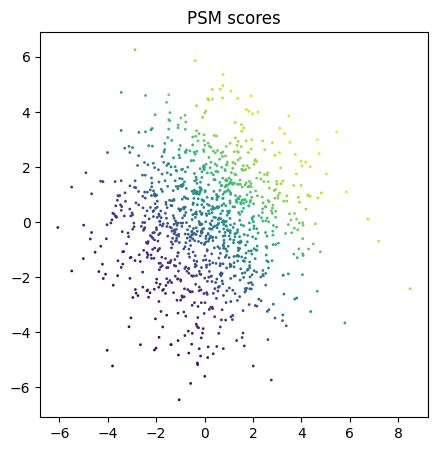

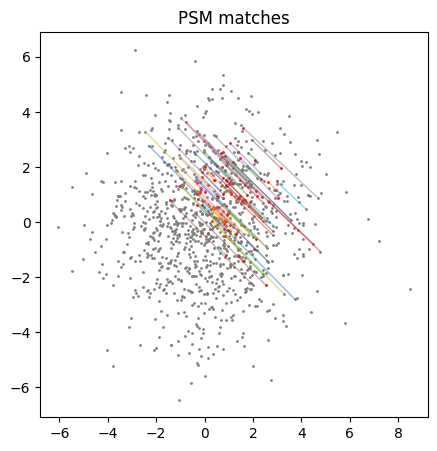

In [11]:
ctl, trt = p._get_ctl_treat_split(p.data)
plot_match(optimal_matching, ctl, trt)

## 1NN matching
as an alternatve to the Optimal matching, we can do simple (greedy) 1st neighbor matchinh

In [12]:
Inn_matching = p.match_1nn(caliper=0.25)
df_matched = p.get_psmatched_dataset(Inn_matching)

INFO:yapsm.psm:Mapped 100 TRT  to 82 CTL
INFO:yapsm.psm:Total cost 0.056


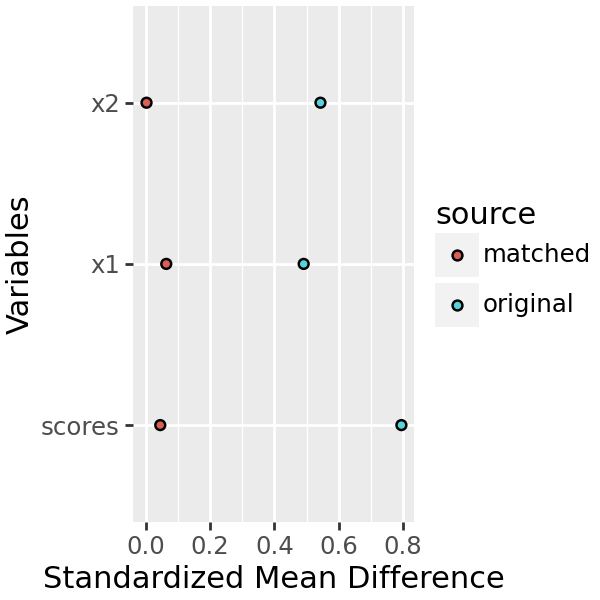

In [13]:
plot_imbalance(data, df_matched, 'group') + pn.theme(figure_size=(3,3)) 

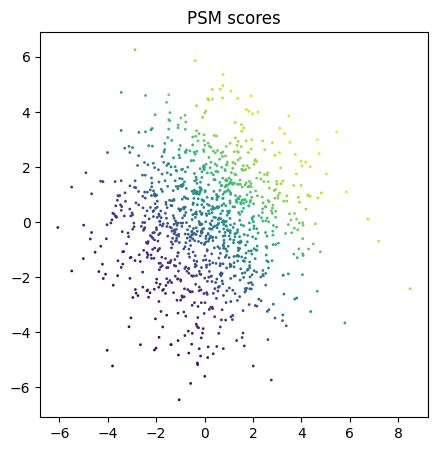

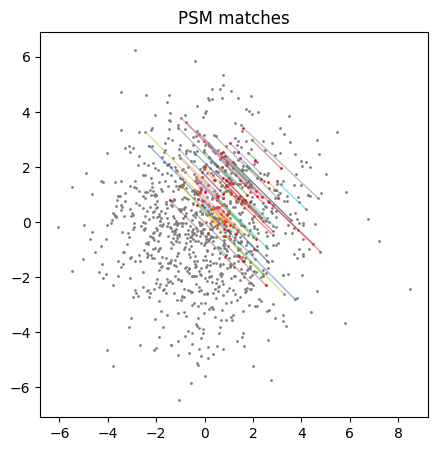

In [14]:
ctl, trt = p._get_ctl_treat_split(p.data)
plot_match(Inn_matching, ctl, trt)

In [15]:
import collections
collections.Counter(Inn_matching.values()).most_common(10)

[('ctl_713', 3),
 ('ctl_60', 3),
 ('ctl_873', 2),
 ('ctl_364', 2),
 ('ctl_304', 2),
 ('ctl_502', 2),
 ('ctl_732', 2),
 ('ctl_705', 2),
 ('ctl_308', 2),
 ('ctl_33', 2)]